## Feature Analysis
### This Notebook is for feature analysis and addresses the following
1. Broad overview of the data we are working with
2. Evaluation of importance of each feature

#### In regards to feature analysis:
We needed a way to determine which features to include in our analysis.
Below you will find two graphs one describing correlation between features and another graph showing word frequency
What we concluded from this analysis was that some features were highly correlated thus provided no additional information.
We took this into consideration when choosing which features should be included.


In [1]:
"""Notebook showing Correlation heatmap for selected features"""

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import warnings
import seaborn as sns
from matplotlib import cm as cm
from textblob import TextBlob
from yellowbrick.features.rankd import Rank2D
from yellowbrick.text import FreqDistVisualizer
from feature_extraction import LemmaTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textstat.textstat import textstat

warnings.simplefilter(action = "ignore", category = FutureWarning)

In [2]:
# Read data
data = pd.read_csv('processed_datascience.csv.bz2')

### Exploratory Stats for Upvotes

Exploratory Stats for Upvotes
count    8856.000000
mean        9.870709
std        21.516689
min         0.000000
25%         1.000000
50%         4.000000
75%         9.000000
max       552.000000
Name: ups, dtype: float64


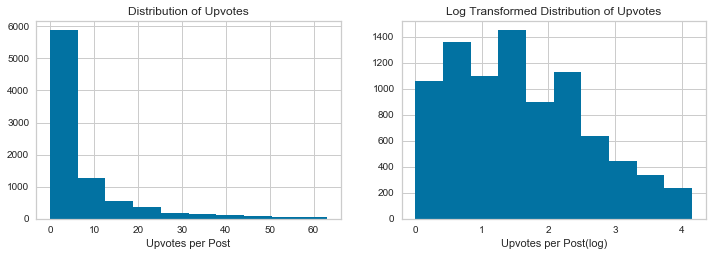

In [3]:
# Stats for Upvotes
print('Exploratory Stats for Upvotes')
print(data.ups.describe())

## Optional: Throw out outliers by including rows with Z-Scores less than 2.5 and greater than -2.5
data['z_scores'] = np.abs((data.ups-data.ups.mean())/data.ups.std())
data = data[data['z_scores']<= 2.5]

## Optional: Log transformation of up-votes
data['log_ups'] = np.log1p(data['ups'])


# Distribution of Upvotes
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.title('Distribution of Upvotes')
plt.hist(data['ups'])
plt.xlabel('Upvotes per Post')

plt.subplot(2,2,2)
plt.title('Log Transformed Distribution of Upvotes')
plt.hist(data['log_ups'])
plt.xlabel('Upvotes per Post(log)')
plt.show()


### Create Features
1.  WordCount - The number of words in the title
2.  CharCount - The number of characters in the title
3.  Vowels - The number of vowels in the title
4.  Consonants - The number of consonants in the title
5.  gtavg - The number of up-votes greater than the average number of up-votes per post
6.  Polarity - The positive or negative sentiment of the title
7.  Subjectivity - Measure of objectivity and subjectivity of each title
8.  Noun Phrases - The number of nouns in each title
9.  Syllable - The number of syllables in each title
10. Kincaid - A score that measures the grade-level of each title
11. Flesch - Measures the readability of each title

In [4]:
# Generate and package data into dataframe
blobs = [TextBlob(sentence) for sentence in data.title]
data['polarity'] = [blob.sentiment.polarity for blob in blobs]
data['subjectivity'] = [blob.sentiment.subjectivity for blob in blobs]
data['noun_phrases'] = [len(blob.noun_phrases) for blob in blobs]

data['gtavg'] = data['ups'] > data.ups.mean()
data['wordcount'] = data['title'].str.split().apply(len)
data['charcount'] = data.title.str.len()
data['vowels'] = data.title.str.findall(r'(?i)([aeiou])').apply(len)
data['consonants'] = data.title.str.findall(r'(?i)([^aeiou])').apply(len)
data['syllable'] = [textstat.syllable_count(x) for x in data.title]
data['kincaid'] = [textstat.flesch_kincaid_grade(x) for x in data.title]
data['flesch'] = [textstat.flesch_reading_ease(x) for x in data.title]

In [5]:
df = data[['gtavg','wordcount','charcount','vowels','consonants', 'syllable', 'polarity',
           'subjectivity', 'noun_phrases', 'kincaid', 'flesch']]

### Examining Pearson Correlation with Yellowbrick
We used Yellowbrick to quickly visualize feature correlation.
This graphic maked sense. There should be a correlation between vowels and syllables, as the number of vowels in a word typically determined the number of syllables.
Because of this graphic, we might consider excluding charcount, vowels, consonants, and syllables.


In [8]:
features = ['wordcount','charcount','vowels','consonants', 'syllable', 
            'polarity', 'subjectivity', 'noun_phrases', 'kincaid', 'flesch' ]
X = data[features].as_matrix()
y = data['gtavg'].as_matrix()

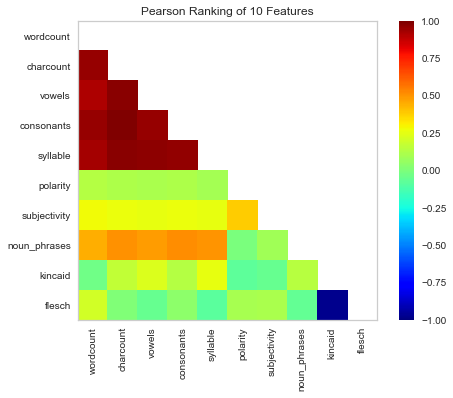

In [9]:
visualizer = Rank2D(features=features, algorithm='pearson', colormap='jet')
visualizer.fit(X,y)
visualizer.transform(X)
visualizer.poof()

In [10]:
a = data[data.ups > data.ups.mean()]['title']
b = data[data.ups <= data.ups.mean()]['title']


### Frequency Distribution of Unigram/Bigrams in Corpus(post titles)
We also needed to examine the words contained in the titles.  Again we use Yellowbrick to generate a frequency distribution chart that showcases the most common terms.  As expected, since we are in /r/datascience, the term data scientist is at the top of the word list.  Most interesting are the themes that become apparent:
1.  Positions (data scientist)
2.  Tools & Topics (big data, python, machine learning, etc)
3.  Employment (career, experience, job, work)
4.  Education (learning, course, masters)

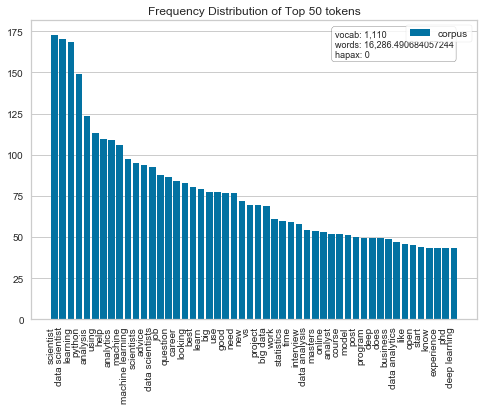

In [11]:
vectorizer = TfidfVectorizer(ngram_range=(1,4),
                             sublinear_tf=True, stop_words='english',
                             max_df=0.2, min_df=10, strip_accents='unicode'
                            )

docs = vectorizer.fit_transform(data.title)
features = vectorizer.get_feature_names()


visualizer = FreqDistVisualizer(features=features, orient='v', n=50)
visualizer.fit(docs)
visualizer.poof()